# Cálculo del operador de azulamiento espectral $\beta$

* [Douglas Alberto Gómez Reyes](agomezr@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Juan Delfino Lara Corona](jdlara@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Liliana Vargas Meleza](lvargasm@imp.mx)- Dirección de Servicios en Exploración y Producción
* [Sergio Chávez Pérez](sergio.chavezp@gmail.com)- Dirección de Tecnología de Producto

**Instituto Mexicano del Petróleo**

### Instrucciones
Para poder reproducir este cuaderno de trabajo, el usuario debe ejecutar la aplicación de [entorno de desarrollo integrado](https://en.wikipedia.org/wiki/Integrated_development_environment) [`Jupyter notebook`](http://jupyter.org/index.html). Es recomendable instalar `Jupyter notebook` a través de [`Anaconda`](https://www.anaconda.com/what-is-anaconda/). Al lector no familiarizado con esta herramienta computacional, le sugerimos consultar los siguientes sitios Web:
- [_Jupyter Notebook for Beginners: A tutorial_ (texto)](https://www.dataquest.io/blog/jupyter-notebook-tutorial/)
- [_Jupyter/IPython Notebook Quick Start Guide_ (texto)](http://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/index.html)
- [_What is Jupyter Notebook?_ (video)](https://www.youtube.com/watch?v=q_BzsPxwLOE)

Instalado `Jupyter notebook` a través de Anaconda, el usuario dispondrá de las principales bibliotecas de [`Python`](https://www.python.org/) que se hacen uso:
- [`Numpy`(_Numerical Python_)](http://www.numpy.org/)
- [`Pandas`(_Python Data Analysis Library_)](https://pandas.pydata.org/)
- [`Matplotlib`(_Mathematics Plotting Library_)](https://matplotlib.org/)
- [`SciPy`(_Scientific Python_)](https://www.scipy.org/)
- [`Seaborn`(_Statistical graphics library_)](https://seaborn.pydata.org/)

Sin embargo, para reproducir este cuaderno de trabajo se requiere la biblioteca [`Las`](https://pypi.org/project/las/), que no se distribuyen  a través de `Anaconda` pero puede instalarse a través de la terminal `Anaconda Promt`, que se instala junto con `Jupyter Notebook` en el ambiente `Windows`, o bien, a través de una terminal en ambiente `Linux`. La biblioteca `Las` permite cargar y leer archivos de datos de registros geofísicos de pozo en formato [LAS (Log ASCII Standard)](http://www.cwls.org/las/) versión 2.0. Otras librerías útiles que complementan la lista de arriba puede consultarse [aquí](https://activewizards.com/blog/top-15-libraries-for-data-science-in-python/).

### Introducción

La señal sísmica puede clasificarse en tres categorías de color con base en las propiedades de su espectro de amplitud $f^\beta$ (Fig. 1). Una señal tiene espectro blanco cuando la energía es la misma para cualquier frecuencia ($\beta$ = 0); en este caso el espectro es plano. Espectro rojo cuando la energía tiende a concentrarse en frecuencias bajas ($\beta$ < 0), y espectro azul cuando la energía tiende a concentrarse en frecuencias altas ($\beta$ > 0).

[Walden y Hosken (1985)](http://gp.eage.org/publication/publicationdetails/?publication=33349) determinaron que el espectro de amplitud de la reflectividad del subsuelo en la escala de medición de los registros geofísicos, tiene una respuesta rica en frecuencias altas y el espectro se ajusta al modelo $f^\beta$ con $\beta$ > 0. Geológicamente, el espectro azul de amplitud de la reflectividad implica un modelo de tierra de pocas capas de gran espesor, pero con un gran número de capas delgadas con respecto a la longitud de onda sísmica predominante, y debido a la naturaleza cuasiperiódica de los eventos sedimentarios de la tierra, los coeficientes de reflexión tienen un espectro azul. [Blache-Fraser y Neep (2004)](https://library.seg.org/doi/abs/10.1190/1.1839675) sugieren que los datos sísmicos deben presentar una tendencia espectral similar a la de los registros de reflectividad.

#### Contrucción sintética de los espectros de color

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.fftpack import fft, ifft
import seaborn as sns 
from obspy.io.segy.segy import _read_segy
from las import LASReader
from tabulate import tabulate
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline
plt.style.use('bmh')

In [2]:
wn = (np.random.randn(2200)) #Señal aleatoria de distribución normal en el dominio del tiempo
wnX = fft(wn) #Transformada de Fourier
a = (np.abs(wnX)) #Parte real de la transformada de Fourier; Espectro de potencia blanco
beta_azul = 0.5 #
beta_rojo = -0.5 #

In [3]:
for color in a:
    b = a*(np.power(np.linspace(1,1000,2200),beta_azul)) #Espectro de potencia azul
    c = a*(np.power(np.linspace(1,1000,2200),beta_rojo)) #Espectro de potencia rojo

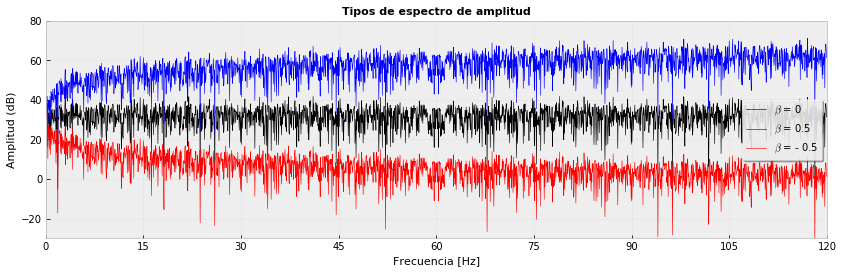

In [4]:
plt.figure(figsize=(14,4))
_ = plt.plot(20*np.log10(a),linestyle ='-',color='k',lw=0.6,label=r'$\beta$ = 0')
_ = plt.plot(20*np.log10(b),linestyle ='-',color='b',lw=0.6,label=r'$\beta$ = 0.5')
_ = plt.plot(20*np.log10(c),color='r',lw=0.6,label=r'$\beta$ = - 0.5')
_ = plt.ylabel('Amplitud (dB)',fontsize=11)
_ = plt.xlabel('Frecuencia [Hz]',fontsize=11)
_ = plt.ylim(-30,80)
_ = plt.xlim(0,120)
_ = plt.legend(loc='center right',shadow=True,fancybox='True',facecolor='white',framealpha=0.8)
_ = plt.xticks(np.linspace(0,2200,9),[0, 15, 30, 45, 60, 75, 90, 105, 120])
_ = plt.title('Tipos de espectro de amplitud',fontsize=11,weight='semibold',color='black')
_ = plt.grid(True,alpha=0.6,linestyle=':')

**Figura 1.** Señales sintéticas con espectros de amplitud blanco ($\beta$ = 0), rojo ($\beta$ = -0.5) y azul ($\beta$ = 0.5) proporcionales a $f^\beta$. El espectro plano indica que la energía de la señal es la misma en todo el ancho de banda; los espectros rojo y azul indican que la energía de las señales está concentrada en las frecuencias bajas y altas, respectivamente.

### Balanceo de datos sísmicos con azulamiento espectral: Implementación 

La técnica para enfatizar el contenido de frecuencias altas extendiendo el ancho de banda sísmico con información de pozos se denomina **azulamiento espectral**. Consiste en aplicar el operador de azulamiento $f^\beta$ que imite el promedio del espectro de amplitud de la serie de reflectividad de un pozo, balanceando espectralmente la amplitud sísmica. La implementación numérica la realizamos con la paquetería de cómputo del consorcio académico de investigación [`AASPI`](http://mcee.ou.edu/aaspi/about.html), de la Universidad de Oklahoma, EEUU.

El filtro azul $a_{j}^{azul}$, se aplica a datos apilados o antes de apilar, mejorando la resolución en el rango de frecuencia de los datos sísmicos utilizados ([Kazemeini et al., 2008](https://library.seg.org/doi/abs/10.1190/1.3063776)), y se describe matemáticamente como ([pág. 27 del programa `spect_cwt` del manual de `AASPI`](http://mcee.ou.edu/aaspi/documentation/Spectral_Attributes-spec_cwt.pdf)):

$a_{j}^{azul} \left( t,f \right) = \left[ \frac{P_{pico}}{P_{prom}(t,f) + \alpha P_{pico}(t)} \right]^ \frac{1}{2} f^\beta a_{j}\left(t,f\right) $

Donde:
* $P_{prom}$: espectro de amplitud promedio
* $P_{pico}$: valor máximo del espectro de amplitud promedio
* $\alpha$: preblanqueamiento
* $a_{j}\left(t,f\right)$: magnitud espectral

El flujo de trabajo implementado para el cálculo de operador $\beta$ se resume como:

1.	Selección del subvolumen sísmico alrededor del pozo. 

2. 	Selección de la ventana de análisis. 

3.	Cálculo de la serie de reflectividad en el pozo a partir de registros geofísicos sónico y densidad.

5.	Calculo del espectro de amplitud de la serie de reflectividad en el pozo.

6.	Ajuste de la función $f^\beta$ al espectro de amplitud de la reflectividad en el pozo para determinar el operador de azulamiento $\beta$. 


Los datos sísmicos y de pozo son propiedad del Departamento de Energía de Nueva Escocia, distribuido por la compañia [`dGB Earth Sciences`](https://dgbes.com/) bajo una licencia CC BY-SA, y disponibles [aquí](https://dgbes.com/index.php/data). Los datos corresponden al estudio marino Penobscot 3D, localizado en la cuenca de Nueva Escocia, Canadá, y registros geofísicos de dos pozos denominados L-30 y B-41. En este cuaderno, el factor de azulamiento $\beta$ lo realizamos en el pozo L-30.

#### Flujo de trabajo

#### 1. Datos de entrada: a) Carga de datos sísmicos y de b) pozo

Seleccionamos la línea transversal no. 1153 que contiene al pozo L-30 (Fig. 2). La profundidad medida del registro geofísico es de 347 a 4252 metros (Tabla 1), por lo que el intervalo de estudio seleccionado corresponde a la franja de tiempo TWT de 1 a 3 segundos.

#### a) Carga de datos sísmicos en formato txt

In [5]:
seccion_sismica = np.loadtxt('PenobXL_1153.txt')
seccion_sismica = seccion_sismica.T #Matriz transpuesta

In [6]:
print('Tamaño de la sección sísmica (matrix) =', seccion_sismica.shape)
print('Amplitud mínima = ', np.min(seccion_sismica))
print('Amplitud máxima = ', np.max(seccion_sismica))

Tamaño de la sección sísmica (matrix) = (753, 401)
Amplitud mínima =  -18392.0
Amplitud máxima =  25210.0


#### b) Carga de los datos de pozo en formato LAS

In [7]:
L30 = LASReader('L-30.las', null_subs=np.nan)
print (L30.curves.names)

['DEPTH', 'CALD', 'CALS', 'DEPT', 'DRHO', 'DT', 'GRD', 'GRS', 'ILD', 'ILM', 'LL8', 'NPHILS', 'NPHISS', 'RHOB', 'SP']


In [8]:
print(L30.curves.DEPTH)#Las unidades de la profundidad son pies, por lo que se deben de convertir a metros.
print(L30.curves.DT)#Las unidades de la lentitud compresional son us/ft, por lo que se deben convertir a us/m. 

name='DEPTH', units='FT', data='', descr='1 Depth'
name='DT', units='US/F', data='', descr='6 Sonic       Delta-T'


Para construir la serie de reflectividad de onda P, se requieren los datos de profundidad 'DEPTH', lentitud de onda P 'DT' y densidad volumétrica 'RHOB'.

Generamos un función para convertir las unidades  de pies a metros, y convertimos las unidades de DTCO y RHOB a $\frac{\mu s}{m}$ y $\frac{kg}{m³}$, respectivamente.  

En la Tabla 1, mostramos los datos de referencia del pozo.

In [9]:
def p2m(medida_en_pies):
    try:
        return medida_en_pies / 3.28084
    except TypeError:
        return float(medida_en_pies) / 3.28084
    return

In [10]:
z = p2m(L30.data['DEPTH'])   
DT = L30.data['DT']*3.28084 #Convertir a us/m     
RHOB = L30.data['RHOB']*1000 #Convertir a kg/m^3 

In [11]:
KB = p2m(L30.well.KB.data)
tirante = p2m(L30.well.GL.data)
vel_agua = 1480 # m/s
elev_SRD = 2 * np.abs(KB) / vel_agua
lecd1 = p2m(L30.start) #Profunidad de inicio del registro
int_remp = p2m(L30.start) - p2m(L30.well.KB.data) + p2m(L30.well.GL.data) #Intervalo de remplazo
vel_remp = 1600 # m/s
agua_twt = 2 * np.abs(tirante + elev_SRD) / vel_agua
remp_twt = 2 * int_remp / vel_remp
tiempo_lecd1 = agua_twt + remp_twt

In [12]:
print(tabulate([['Parámetro de referencia','Magnitud', 'Unidad'],
                 ['KB: datum de referencia', np.round(KB,4),'m'],
                 ['Tirante de agua',np.round(tirante,4), 'm'],
                 ['Inicio de medición del registro',np.round(lecd1,4), 'm'],
                 ['Intervalo de remplazo', np.round(int_remp,4),'m'],
                 ['Velocidad del agua', np.round(vel_agua,4), 'm/s'],
                 ['Velocidad de remplazo', np.round(vel_remp,4),'m/s'],
                 ['Elevación sobre el nivel del mar ', np.round(elev_SRD,5), 's'],
                 ['Tiempo doble de viaje de remplazo',np.round(remp_twt,5),'s'],
                 ['Tiempo doble de viaje de inicio de registro',np.round(tiempo_lecd1,5),'s']],
    headers="firstrow", tablefmt='grid', numalign='center'))

+---------------------------------------------+------------+----------+
| Parámetro de referencia                     |  Magnitud  | Unidad   |
+=============================================+============+==========+
| KB: datum de referencia                     |  30.1752   | m        |
+---------------------------------------------+------------+----------+
| Tirante de agua                             |  -137.465  | m        |
+---------------------------------------------+------------+----------+
| Inicio de medición del registro             |  347.472   | m        |
+---------------------------------------------+------------+----------+
| Intervalo de remplazo                       |  179.832   | m        |
+---------------------------------------------+------------+----------+
| Velocidad del agua                          |    1480    | m/s      |
+---------------------------------------------+------------+----------+
| Velocidad de remplazo                       |    1600    | m/s

**Tabla 1.** Datos de referencia del pozo.

#### 2. Aréa de estudio

En la Fig. 2 graficamos el sección original. Sin embargo, debido a los valores de amplitud del fondo oceánico se enmascaran las amplitudes por debajo de los 0.3 segundos. Para apreciar la distribución de amplitudes, en la Fig. 3 graficamos el histograma de la sección sísmica. En la Fig. 4, para fines de vizualización, volvemos a graficar la sección sísmica con todos los valores por debajo del percentil 99. 

En la Fig. 5 mostramos la sección sísmica en en área de interés, que es de 1 a 3 segundos.


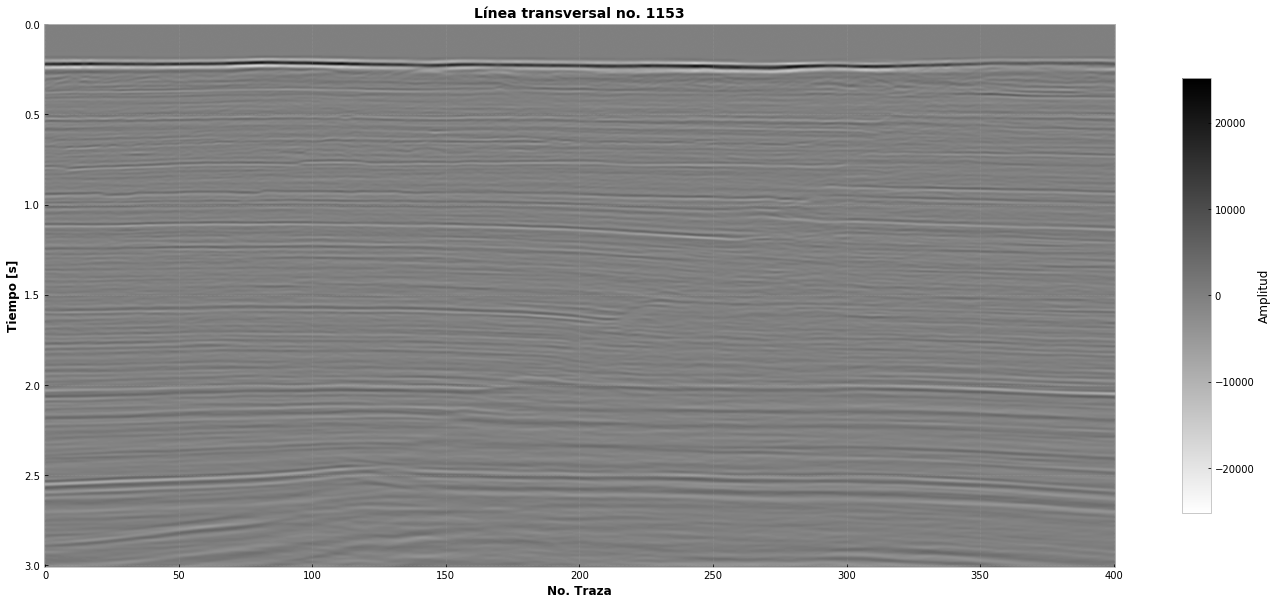

In [13]:
plt.figure(figsize=[24,10])

percen_1 = np.percentile(seccion_sismica, 100)

im1 = plt.imshow(seccion_sismica[:,:],vmin=-percen_1, vmax=percen_1, cmap="binary", aspect='auto',
                interpolation='gaussian')
cbar= plt.colorbar(im1, aspect=15, shrink=0.8)
cbar.set_label('Amplitud')
_ = plt.yticks(np.linspace(0,750,7), [0.0,0.5,1.0,1.5,2.0,2.5, 3.0])
_ = plt.xlabel('No. Traza', fontsize = 12, weight = 'semibold')
_ = plt.ylabel('Tiempo [s]', fontsize = 12, weight = 'semibold')
_ = plt.title('Línea transversal no. 1153', fontsize=14, weight = 'semibold')
_ = plt.grid(True,alpha=0.6,linestyle=':')

**Figura 2.** Sección sísmica original.

In [14]:
percen_2 = np.percentile(seccion_sismica, 99)
print('Percentil 99 =', percen_2)

Percentil 99 = 4596.0


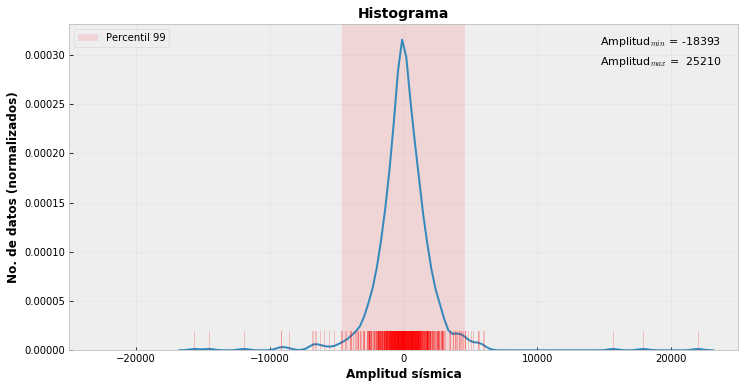

In [15]:
plt.figure(figsize=[12,6])
_ = sns.distplot(seccion_sismica.T[13], hist = False, norm_hist = False)
_ = sns.rugplot(seccion_sismica.T[13], height = 0.06, alpha = 0.2, color = 'r')
_ = plt.axvspan(-percen_2, percen_2, alpha = 0.1, facecolor = 'r', label = 'Percentil 99')
_ = plt.text(14650, 0.000310, 'Amplitud$_{min}$ = -18393', fontsize=11, color = 'k')
_ = plt.text(14650, 0.000290, 'Amplitud$_{max}$ =  25210', fontsize=11, color = 'k')
_ = plt.xlim(-25000,25000)
_ = plt.xlabel('Amplitud sísmica', fontsize = 12, weight = 'semibold')
_ = plt.ylabel('No. de datos (normalizados)', fontsize = 12, weight = 'semibold')
_ = plt.title('Histograma', fontsize = 14, weight = 'semibold')
_ = plt.legend(loc = 'upper left')
_ = plt.grid(True,alpha=0.6,linestyle=':')

**Figura 3.** Histograma de amplitud sísmica.

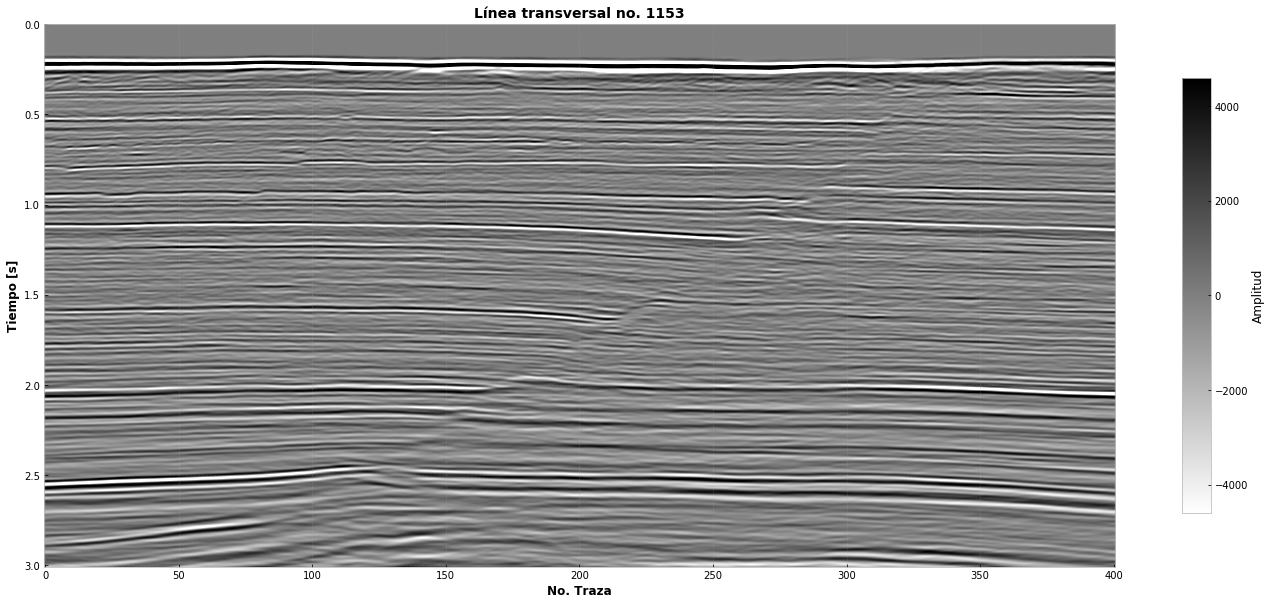

In [16]:
plt.figure(figsize=[24,10])

im1 = plt.imshow(seccion_sismica[:,:],vmin=-percen_2, vmax=percen_2, cmap="binary", aspect='auto',
                interpolation='gaussian')
cbar= plt.colorbar(im1, aspect=15, shrink=0.8)
cbar.set_label('Amplitud')
_ = plt.yticks(np.linspace(0,750,7), [0.0,0.5,1.0,1.5,2.0,2.5, 3.0])
_ = plt.xlabel('No. Traza', fontsize = 12, weight = 'semibold')
_ = plt.ylabel('Tiempo [s]', fontsize = 12, weight = 'semibold')
_ = plt.title('Línea transversal no. 1153', fontsize=14, weight = 'semibold')
_ = plt.grid(True,alpha=0.6,linestyle=':')

**Figura 4.** Sección sísmica orginal con percentil 99 de amplitud.

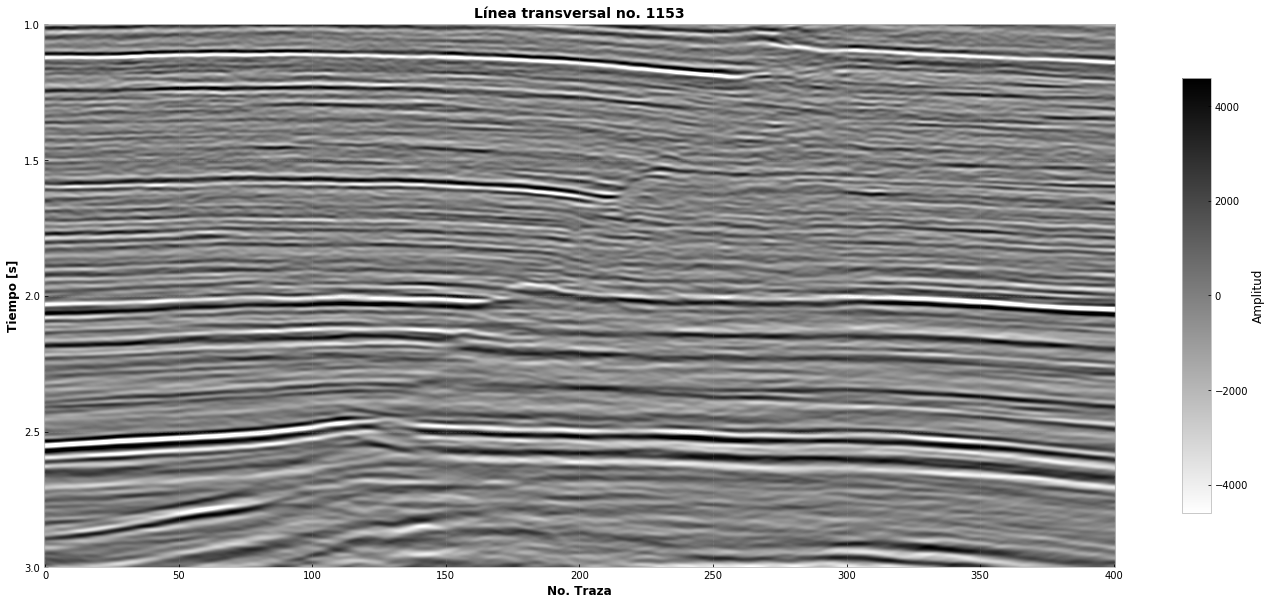

In [17]:
plt.figure(figsize=[24,10])

seccion_estudio = seccion_sismica[250:750,]

im2 = plt.imshow(seccion_estudio,vmin=-percen_2, vmax=percen_2, cmap="binary", aspect='auto',
                interpolation='gaussian')
cbar= plt.colorbar(im2, aspect=15, shrink=0.8)
cbar.set_label('Amplitud')
_ = plt.yticks(np.linspace(0,500,5), [1.0,1.5,2.0,2.5, 3.0])
_ = plt.xlabel('No. Traza', fontsize=14)
_ = plt.xlabel('No. Traza', fontsize = 12, weight = 'semibold')
_ = plt.ylabel('Tiempo [s]', fontsize = 12, weight = 'semibold')
_ = plt.title('Línea transversal no. 1153', fontsize=14, weight = 'semibold')
_ = plt.grid(True,alpha=0.6,linestyle=':')

**Figura 5.** Sección sísmica de interés.

#### 3. Serie de reflectividad

En la Fig.6 suavizamos los registros de DTCO y RHOB, eliminando los valor impulsivos (Bianco, 2014), y a partir el registro DTCO, calculamos la curva de tiempo a profundidad integrando el registro DTCO (Fig. 7). 

In [18]:
dts = signal.medfilt(DT,17) #DT suavizada
rhobs = signal.medfilt(RHOB,17) #RHOB suavizada

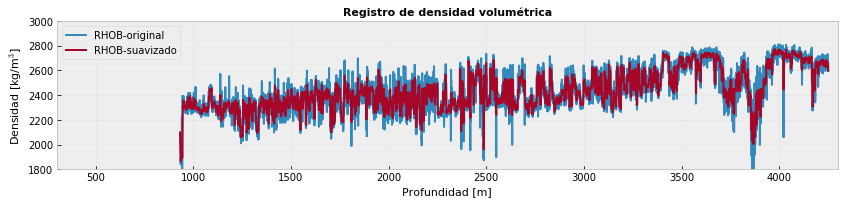

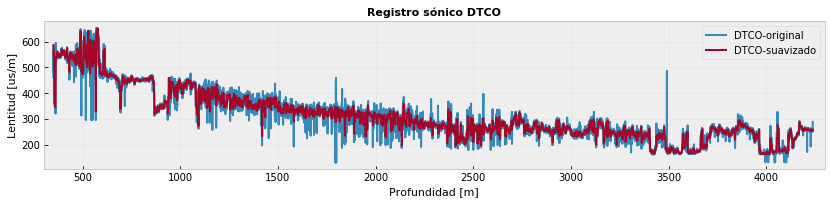

In [19]:
plt.figure(figsize=[14,6])
plt.subplot(2,1,1)
_ = plt.plot(z, RHOB, label = 'RHOB-original')
_ = plt.plot(z, rhobs, label = 'RHOB-suavizado')
_ = plt.xlim(300, 4300)
_ = plt.ylim(1800, 3000)
_ = plt.grid(True, alpha = 0.6, linestyle=':')
_ = plt.legend()
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Densidad [kg/m$^3$]', fontsize=11)
_ = plt.title('Registro de densidad volumétrica', fontsize=11, weight = 'semibold', color='black')

plt.figure(figsize=[14,6])
plt.subplot(2,1,1)
_ = plt.plot(z, DT, label = 'DTCO-original')
_ = plt.plot(z, dts, label = 'DTCO-suavizado')
_ = plt.xlim(300, 4300)
#_ = plt.ylim(1800, 3000)
_ = plt.grid(True, alpha = 0.6, linestyle=':')
_ = plt.legend()
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Lentitud [us/m]', fontsize=11)
_ = plt.title('Registro sónico DTCO', fontsize=11, weight = 'semibold', color='black')

**Figura 6.** Registros de RHOB y DTCO suavizados.

In [20]:
scaled_dt = 0.1524 * np.nan_to_num(dts) / 1e6
tcum = 2 * np.cumsum(scaled_dt)
tdr = tcum + tiempo_lecd1 #Curva TZ

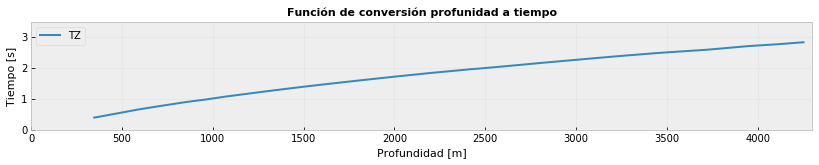

In [21]:
plt.figure(figsize=[14,2])
_ = plt.plot(z,tdr, label = 'TZ', lw=2)
_ = plt.xlim(0, 4300)
_ = plt.ylim(0, 3.5)
_ = plt.grid(True, alpha = 0.6, linestyle=':')
_ = plt.legend()
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Tiempo [s]', fontsize=11)
_ = plt.title('Función de conversión profunidad a tiempo', fontsize=11, weight = 'semibold', color='black')

**Figura 7.** Curva TZ.

En la Fig. 8 calculamos la impedancia de onda P y en la Fig. 9 la serie de reflectividad.

En la Fig. 10 graficamos las curvas lentitud de onda P, densidad volumétrica, impedancia acústica y serie de reflectividad en una misma plantilla.

In [22]:
#Se reescalan las variables dt, rhob, tdr, z, debido a la existencia de ceros en la inicio y final
dts = dts[5:-5]
z = z[5:-5]
rhobs = rhobs[5:-5]
tdr = tdr[5:-5]
tcum = tcum[5:-5]

In [23]:
imp = (1e6/dts) * rhobs
sr = (imp[1:] - imp[:-1]) / (imp[1:] + imp[:-1])

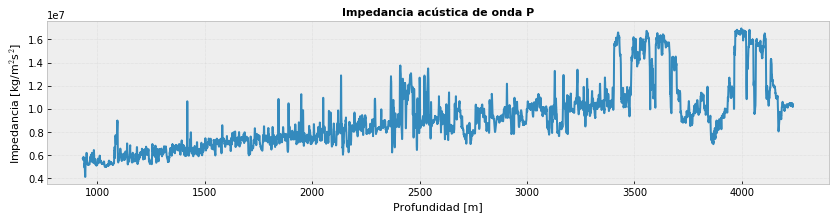

In [24]:
plt.figure(figsize=[14,3])

_ = plt.plot(z, imp)
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Impedancia [kg/m$^2$s$^2$]', fontsize=11)
_ = plt.title('Impedancia acústica de onda P', fontsize=11, weight = 'semibold', color='black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')


**Figura 8.** Curva de impedancia acústica.

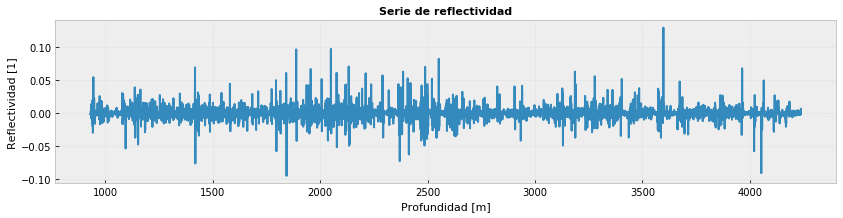

In [25]:
plt.figure(figsize=[14,3])
_ = plt.plot(z[:-1],sr)
_ = plt.xlabel('Profundidad [m]', fontsize=11)
_ = plt.ylabel('Reflectividad [1]', fontsize=11)
_ = plt.title('Serie de reflectividad', fontsize=11, weight = 'semibold', color='black')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

**Figura 9.** Serie de reflectividad.

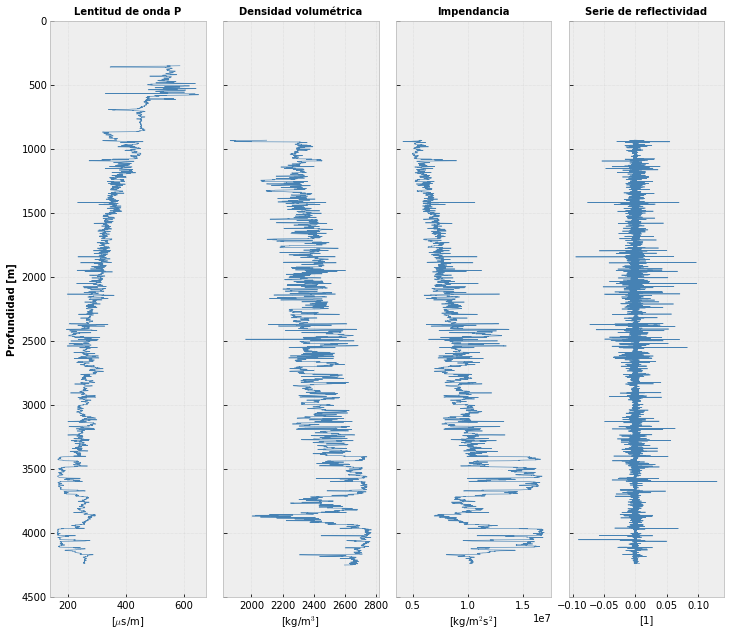

In [26]:
f1 = plt.figure(figsize = (12,10))

ax1 = f1.add_axes([0.1, 0.1, 0.18, 0.8])
ax1.plot( dts, z,'b', alpha=1, color = 'steelblue', lw=0.6)
ax1.set_title('Lentitud de onda P', style = 'normal', fontsize = 10, weight = 'semibold')
ax1.set_ylabel('Profundidad [m]', fontsize = 10, weight = 'black')
ax1.set_xlabel('[$\mu$s/m]', fontsize = 10)
ax1.set_ylim(0, 4500)
ax1.invert_yaxis()
ax1.grid(True, alpha = 0.6, linestyle=':')

ax2 = f1.add_axes([0.3 , 0.1, 0.18, 0.8])
ax2.plot(rhobs, z, 'b', alpha = 1, color = 'steelblue', lw=0.6)
ax2.set_title('Densidad volumétrica', style = 'normal', fontsize = 10, weight = 'semibold')
ax2.set_xlabel('[kg/m$^3$]', fontsize = '10')
ax2.invert_yaxis()
ax2.set_yticklabels('')
ax2.set_ylim(4500, 0)
ax2.grid(True, alpha = 0.6, linestyle=':')

ax3 = f1.add_axes([0.5, 0.1, 0.18, 0.8])
ax3.plot( imp, z, 'k', alpha=1, color = 'steelblue', lw=0.6)
ax3.set_title('Impendancia', style = 'normal', fontsize = 10, weight = 'semibold')
ax3.set_xlabel('[kg/m$^2$s$^2$]', fontsize = '10')
ax3.invert_yaxis()
ax3.set_yticklabels('')
ax3.set_ylim(4500, 0)
ax3.grid(True, alpha = 0.6, linestyle=':')

ax4 = f1.add_axes([0.7, 0.1, 0.18, 0.8])
ax4.plot( sr, z[:-1], 'k', alpha=1, color = 'steelblue', lw=0.6)
ax4.set_title('Serie de reflectividad', style = 'normal', fontsize = 10, weight = 'semibold')
ax4.set_xlabel('[1]', fontsize = '10')
ax4.invert_yaxis()
ax4.set_yticklabels('')
ax4.set_ylim(4500, 0)
ax4.grid(True, alpha = 0.6, linestyle=':')

**Figura 10.** Conjunto de curvas en el dominio de la profundidad.

### Conversión profundidad a tiempo: Remuestreo de la impedancia

Escalamos la serie de reflectividad del dominio de la profundidad a tiempo y la gráficamos en la posición correspondiente del pozo L-30 en la sección sísmica (Fig. 11).

In [27]:
dt = 0.004 #Intervalo de muestreo
maxt = 3.0 #Tiempo máximo
t = np.arange(0, maxt, dt) #Vector de tiempo 
imp_t = np.interp(x = t, xp = tdr, fp = imp) #Impedancia de onda P en el dominio del tiempo
sr_t = (imp_t[1:] - imp_t[:-1]) / (imp_t[1:] + imp_t[:-1]) #Serie de reflectividad en el dominio del tiempo

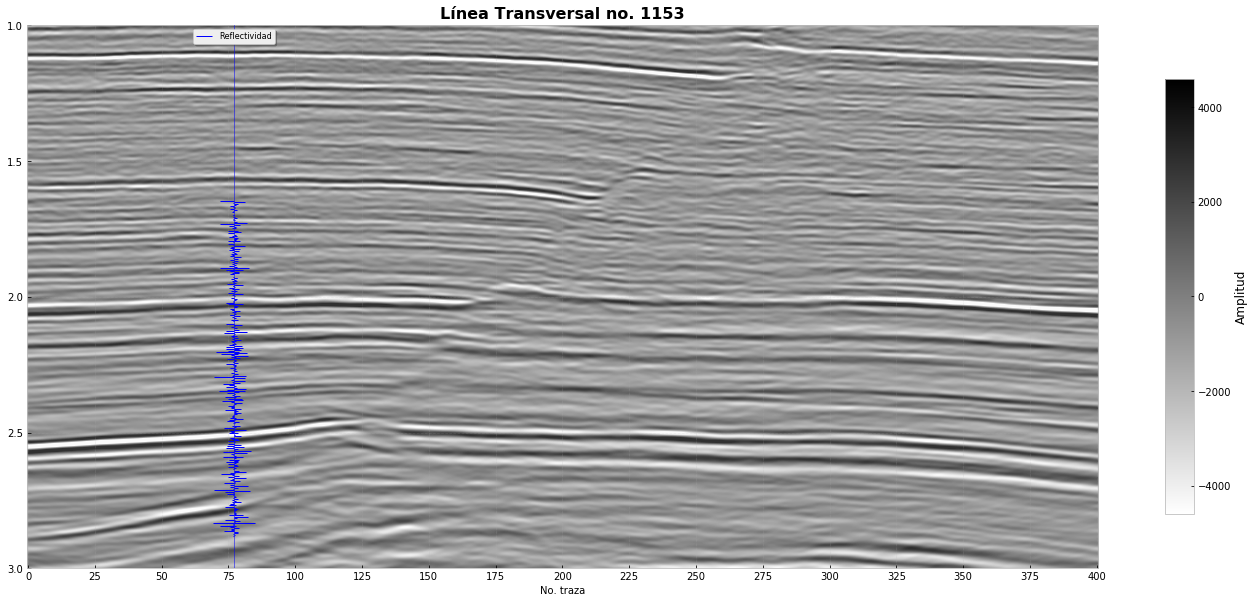

In [28]:
f3 = plt.figure(figsize=[24,10])
gs = gridspec.GridSpec(1,1)
      
ax1 = plt.subplot(gs[0])

ax1.imshow(seccion_estudio, cmap = 'binary', vmin = -percen_2, vmax = percen_2, alpha = 0.8,
           aspect = 'auto', interpolation='gaussian')
ax1.set_title('Línea Transversal no. 1153', fontsize = 16, weight = 'semibold')
ax1.set_xlabel('No. traza', fontsize = 10)
plt.yticks(np.linspace(0,500,5), [1.0,1.5,2.0,2.5,3.0])
plt.xticks(np.linspace(0,400,17), [0,25,50,75,100,125,150,175,200,225,250,275,300,325,350,375,400])
ax1.grid(True, alpha = 0.6, linestyle=':')
cbar= plt.colorbar(im2, aspect=15, shrink=0.8)
cbar.set_label('Amplitud')

# Serie de reflectividad
bottom = ax1.get_position().get_points()[0][1]
top =  ax1.get_position().get_points()[1][1]

ax2 = ax1.figure.add_axes([0.22, bottom, 0.05, top-bottom])
ax2.hlines(t[:-1], 0, sr_t, color='b', alpha=1, lw=1, label = 'Reflectividad')        
ax2.plot([0, 0], [t.min(), t.max()], '-', c='b', alpha = 1, lw=0.5)    
ax2.legend(loc = 'upper center', shadow = True, fontsize = 8)
ax2.set_xlabel('', fontsize = '12')
ax2.set_ylim(0, 3)
ax2.set_xlim(-0.5 ,0.5)
ax2.invert_yaxis()
ax2.set_axis_off()
ax2.grid()

**Figura 11.** Sección sísmica de estudio y serie de reflectividad del pozo L-30.

#### 4. Ajuste de la función $f^\beta$  al espectro de amplitud de reflectividad para determinar $\beta$ 

El operador de azulamiento $\beta$ modela los espectros de amplitud de los datos sísmicos y de pozo
dentro del ancho de banda de los datos sísmicos. [Kazemeini et al. (2010)](https://library.seg.org/doi/10.1190/1.3483900) recomiendan emplear un
método de optimización o de cuadrados mínimos para ajustar la función $f^\beta$. Con base en [Kwietniak et al. (2018)](https://library.seg.org/doi/abs/10.1190/INT-2017-0196.1), aproximamos el espectro de amplitud de la serie de reflectividad a través de una función exponencial y continua a $\alpha f^\beta$. Para ello realizamos:

* Creamos una función que represente el modelo: espectro de amplitud de la serie de reflectividad
* Definimos una función objetivo: $y=\alpha*x^\beta+\delta$
* Hacemos un ajuste de cuadrados mínimos a través de la biblioteca [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)

La Fig. 12 muestra el espectro de amplitud de la serie de reflectividad del subsuelo en la posición del pozo L-30. La Fig. 13 muestra el factor de ajuste (factor de azulamiento) del espectro del pozo. En este ejercicio, el factor de azulamiento $\beta$ = 0.2840.


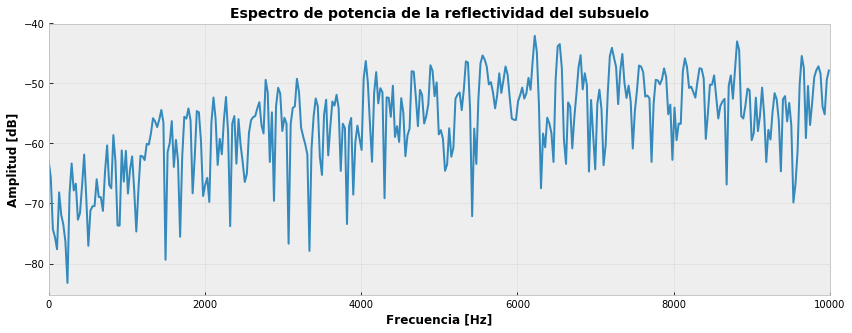

In [29]:
sr_t = np.nan_to_num(sr_t)

plt.figure(figsize=(14,5))

azul = plt.magnitude_spectrum(sr_t, Fs=20000, label='Traza original', scale='dB')
_ = plt.ylabel('Amplitud [dB]', fontsize = 12, weight = 'semibold')
_ = plt.xlabel('Frecuencia [Hz]', fontsize = 12, weight = 'semibold')
_ = plt.title('Espectro de potencia de la reflectividad del subsuelo', fontsize = 14, weight = 'semibold')
_ = plt.xlim(0,10000)
_ = plt.grid(True, alpha = 6, linestyle=':')

**Figura 12.** Espectro de amplitud en decibeles de la serie de reflectividad del subsuelo.

In [30]:
energia_lineal = azul[0][0:2500]
energia_dB = 20*np.log10(azul[0])[0:2500]
frecs = azul[1][0:2500]

In [31]:
def func_dB(x, a, b, c):
    'función objetivo'
    return a*x**b + c

In [32]:
popt_dB, pcov_dB = curve_fit(func_dB, frecs, energia_dB, method='dogbox')

In [33]:
print('Factor de azulamiento =',(np.round(popt_dB[1],4)))

Factor de azulamiento = 0.284


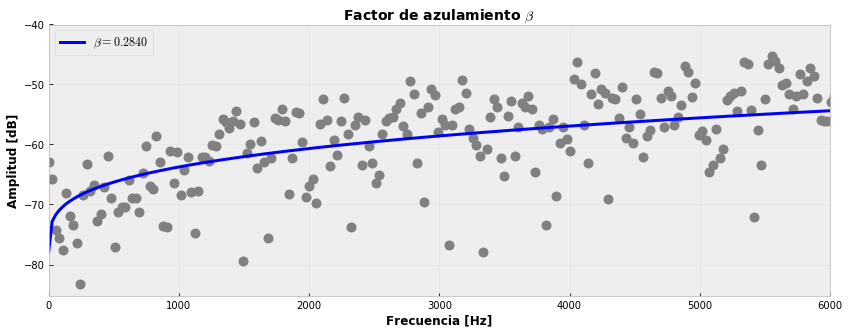

In [34]:
plt.figure(figsize=(14,5))

_ = plt.plot(frecs, energia_dB,  linestyle ='', marker="o",
                           markersize=9, color='grey')
_ = plt.plot(frecs, func_dB(frecs, *popt_dB), lw=3, color='b', label=r'$\beta=%0.4f$' % popt_dB[1])
_ = plt.ylabel('Amplitud [dB]', fontsize = 12, weight = 'semibold')
_ = plt.xlabel('Frecuencia [Hz]', fontsize = 12, weight = 'semibold')
_ = plt.xlim(0,6000)
_ = plt.legend(loc='upper left',fontsize = 12)
_ = plt.title(r'Factor de azulamiento $\beta$', fontsize = 14, weight = 'semibold')
_ = plt.grid(True, alpha = 0.6, linestyle=':')

**Figura 13.** Cálculo del factor de azulamiento $\beta$.